In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [9]:
TRAINING_DIR = "data_1/train"
VALIDATION_DIR = "data_1/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))

Found 6191 images belonging to 41 classes.


In [10]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        target_size=(128, 128))


Found 1507 images belonging to 41 classes.


In [11]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(128, 128, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output


In [12]:
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(41, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [15]:
int_lr = 1e-4
num_epochs = 200

optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9 and logs.get('accuracy')>0.9):
      print('accuracy and validation accuracy reach 90%')
      self.model.stop_training = True

mycallback = myCallback()

In [17]:
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              callbacks=mycallback)


Epoch 1/1000
194/194 [==============================] - 129s 638ms/step - loss: 3.9602 - accuracy: 0.2234 - val_loss: 2.3184 - val_accuracy: 0.4466
Epoch 2/1000
194/194 [==============================] - 118s 606ms/step - loss: 2.8340 - accuracy: 0.3764 - val_loss: 2.0656 - val_accuracy: 0.5056
Epoch 3/1000
194/194 [==============================] - 116s 599ms/step - loss: 2.5050 - accuracy: 0.4414 - val_loss: 1.9792 - val_accuracy: 0.5375
Epoch 4/1000
194/194 [==============================] - 126s 651ms/step - loss: 2.3617 - accuracy: 0.4649 - val_loss: 1.9618 - val_accuracy: 0.5461
Epoch 5/1000
194/194 [==============================] - 119s 615ms/step - loss: 2.2340 - accuracy: 0.4897 - val_loss: 2.0022 - val_accuracy: 0.5474
Epoch 6/1000
194/194 [==============================] - 118s 605ms/step - loss: 2.1495 - accuracy: 0.5052 - val_loss: 1.9970 - val_accuracy: 0.5654
Epoch 7/1000
194/194 [==============================] - 115s 595ms/step - loss: 2.0515 - accuracy: 0.5241 - val_

KeyboardInterrupt: 

In [18]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


NameError: name 'H' is not defined

<Figure size 1000x500 with 0 Axes>

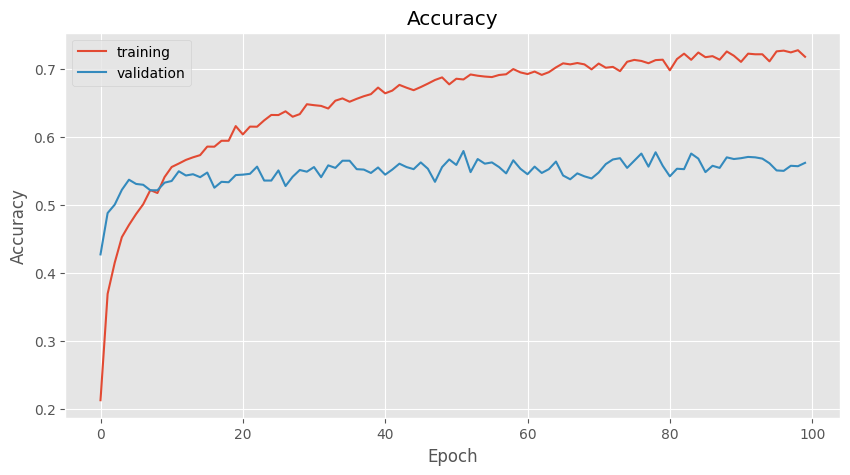

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## save model


In [14]:
model.save_weights('weights/weights_mobilenet-000/weights')

In [19]:
import os
model.save(os.path.join('models/h5', 'explorentt_mobilenet.h5'))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
!tensorflowjs_converter --input_format=keras models/h5/explorentt_1.h5 models/h5-tfjs


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <module>
    from tensorflowjs.converters import tf_saved_model_conversion_v2
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflowjs\converters\tf_saved_model_conversion_v2.py", line 2